In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2 as cv
import skimage as ski

import io
import pandas as pd
import numpy as np
import sklearn as skl
from PIL import Image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

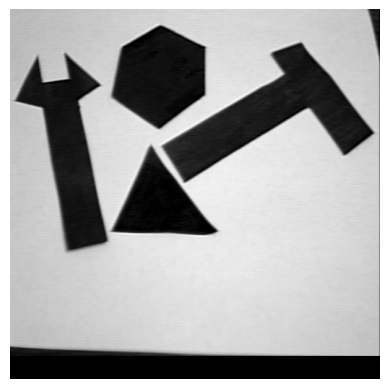

In [2]:
# image=np.fromfile('comb.img', dtype=np.uint8)
# image = image.reshape((513,512))

# plt.imshow(image, cmap='gray')
# plt.axis('off')
with open('comb.img', 'rb') as f:
    f.read(512)  # strip header
    image = np.fromfile(f, dtype=np.uint8, count=512*512)
image = image.reshape((512, 512))
plt.imshow(image, cmap='gray')
plt.axis('off')

# Thresholding the image
Threshold Value represented by variable T, where `T=128`

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

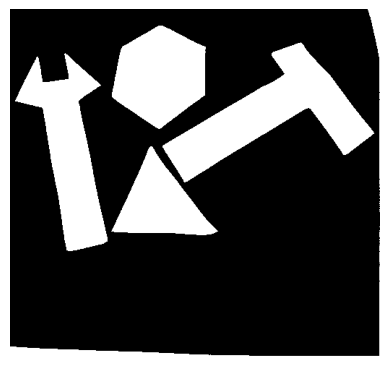

In [3]:
threshold = 128
threshold_image = image < threshold

plt.imshow(threshold_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

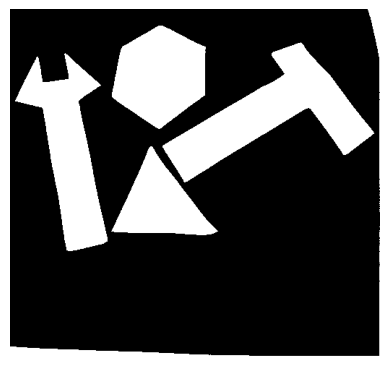

In [4]:
BT = np.zeros(image.shape, dtype=np.uint8)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i, j] < threshold:
            BT[i, j] = 1
        else:
            BT[i, j] = 0
plt.imshow(BT, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

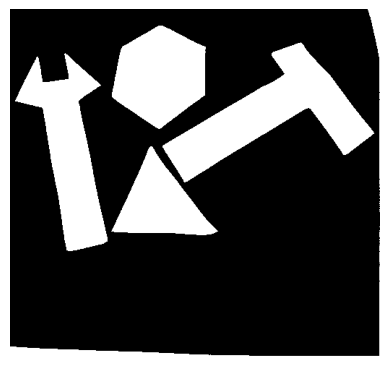

In [5]:
BT = np.where(image < threshold, 1, 0).astype(np.uint8)
plt.imshow(BT, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

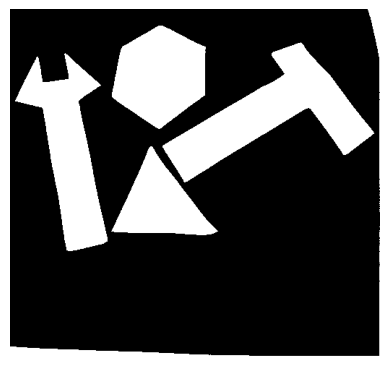

In [6]:
BT = np.zeros_like(image, dtype=np.uint8)
BT[image >= threshold] = 0
BT[image < threshold] = 1
plt.imshow(BT, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

In [7]:
BT

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [8]:
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
labels = np.zeros_like(BT, dtype=np.int32)
current_label = 0
components = {}
rows, cols = BT.shape
# https://www.amazon.com/CLARKS-Womens-May-Marigold-Leather/dp/B006R4Q66A/

# https://www.amazon.com/Clarks-Womens-Loafer-Tumbled-Leather/dp/B01MYY5E0B/

for i in range(rows):
    for j in range(cols):
        if BT[i, j] == 1 and labels[i, j] == 0:
            current_label += 1
            stack = [(i, j)]
            labels[i, j] = current_label
            pixels = []

            while stack:
                x, y = stack.pop()
                pixels.append((x, y))

                for dx, dy in neighbors:
                    nx, ny = x + dx, y + dy
                    if (0 <= nx < rows and 0 <= ny < cols and
                        BT[nx, ny] == 1 and labels[nx, ny] == 0):
                        labels[nx, ny] = current_label
                        stack.append((nx, ny))

            components[current_label] = pixels
min_size = 800
filtered_components = {
    label: pixels
    for label, pixels in components.items()
    if len(pixels) >= min_size
}

num_components = len(filtered_components)
print("Number of components meeting size requirement:", num_components)


Number of components meeting size requirement: 5


In [9]:
import math
features = {}

for label, pixels in filtered_components.items():
    coords = np.array(pixels)
    rows_c = coords[:, 0]
    cols_c = coords[:, 1]

    # (i) Area
    area = len(pixels)

    # (ii) Centroid
    centroid_row = rows_c.mean()
    centroid_col = cols_c.mean()

    # (iii) Bounding box
    min_r, max_r = rows_c.min(), rows_c.max()
    min_c, max_c = cols_c.min(), cols_c.max()

    # Centralized coordinates
    x = cols_c - centroid_col
    y = rows_c - centroid_row

    # (iv) Orientation (principal axis)
    mu11 = np.mean(x * y)
    mu20 = np.mean(x ** 2)
    mu02 = np.mean(y ** 2)

    orientation = 0.5 * math.atan2(2 * mu11, mu20 - mu02)

    # (v) Eccentricity
    cov = np.array([[mu20, mu11],
                    [mu11, mu02]])
    eigvals = np.linalg.eigvals(cov)
    eigvals = np.sort(eigvals)

    eccentricity = np.sqrt(1 - eigvals[0] / eigvals[1]) if eigvals[1] > 0 else 0

    # Perimeter (4-connected)
    perimeter = 0
    pixel_set = set(pixels)
    for r, c in pixels:
        for dr, dc in neighbors:
            if (r + dr, c + dc) not in pixel_set:
                perimeter += 1

    # Compactness
    compactness = (perimeter ** 2) / area

    features[label] = {
        "area": area,
        "centroid": (centroid_row, centroid_col),
        "bbox": (min_r, min_c, max_r, max_c),
        "orientation": orientation,
        "eccentricity": eccentricity,
        "perimeter": perimeter,
        "compactness": compactness
    }


In [10]:
for label, f in features.items():
    print(f"\nComponent {label}")
    for k, v in f.items():
        print(f"  {k}: {v}")



Component 2
  area: 13139
  centroid: (np.float64(91.73491133267372), np.float64(207.32978156632925))
  bbox: (np.int64(23), np.int64(141), np.int64(165), np.int64(270))
  orientation: -0.86246615754126
  eccentricity: 0.38755428589510693
  perimeter: 550
  compactness: 23.023061115762236

Component 3
  area: 19742
  centroid: (np.float64(146.54685442204436), np.float64(361.0750683821295))
  bbox: (np.int64(46), np.int64(211), np.int64(239), np.int64(503))
  orientation: -0.34147841627048137
  eccentricity: 0.905321380062873
  perimeter: 1140
  compactness: 65.8291966366123

Component 4
  area: 15311
  centroid: (np.float64(196.6285676964274), np.float64(81.30853634641761))
  bbox: (np.int64(61), np.int64(7), np.int64(334), np.int64(134))
  orientation: 1.3786063454893427
  eccentricity: 0.963083550872414
  perimeter: 948
  compactness: 58.69662334269479

Component 7
  area: 8907
  centroid: (np.float64(269.835410351409), np.float64(207.20758953631974))
  bbox: (np.int64(190), np.int6

In [11]:
C = np.zeros_like(labels)

new_label = 1
for label, pixels in filtered_components.items():
    for r, c in pixels:
        C[r, c] = new_label
    new_label += 1


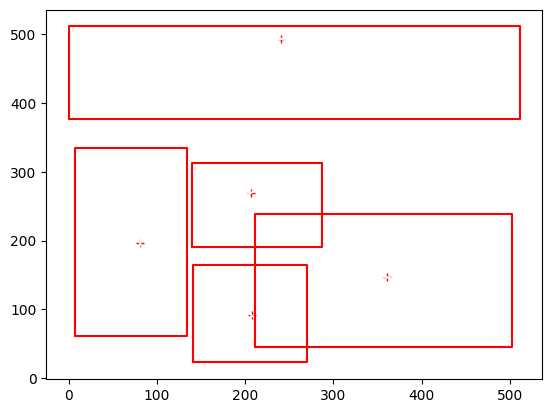

In [12]:
for label, f in features.items():
    cy, cx = f["centroid"]
    min_r, min_c, max_r, max_c = f["bbox"]
    theta = f["orientation"]

    # Centroid
    plt.plot(cx, cy, 'r+')

    # Bounding box
    plt.plot([min_c, max_c, max_c, min_c, min_c],
             [min_r, min_r, max_r, max_r, min_r], 'r')

    # Orientation axis
    length = 30
    dx = length * np.cos(theta)
    dy = length * np.sin(theta)
    plt.plot([cx - dx, cx + dx], [cy - dy, cy + dy], 'w')


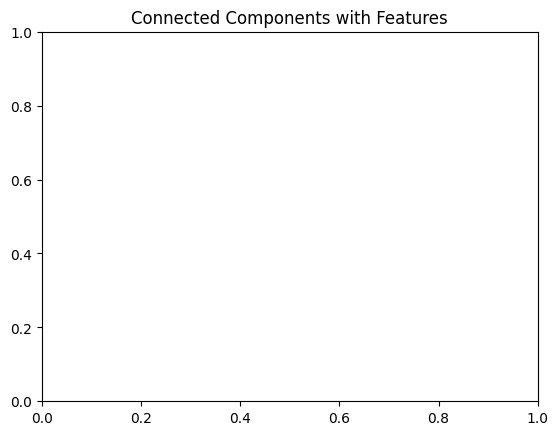

In [13]:
plt.title("Connected Components with Features")
plt.show()

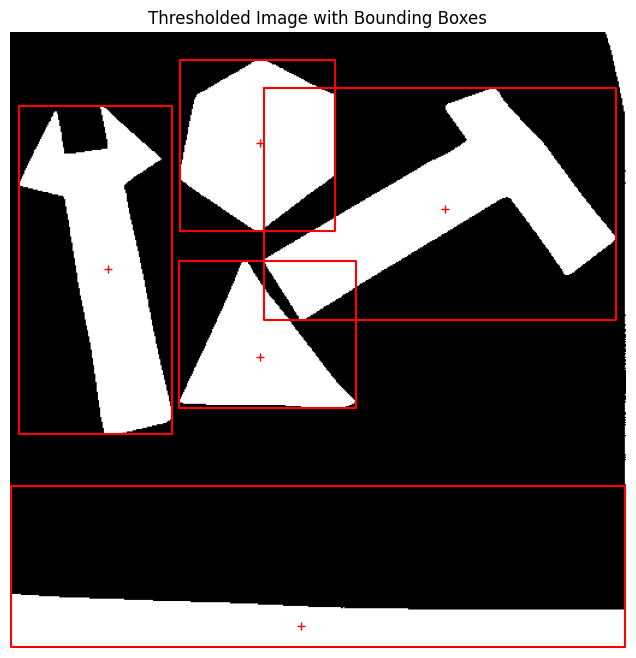

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(BT, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

for f in features.values():
    cy, cx = f["centroid"]
    min_r, min_c, max_r, max_c = f["bbox"]

    plt.plot(cx, cy, 'r+')
    plt.plot([min_c, max_c, max_c, min_c, min_c],
             [min_r, min_r, max_r, max_r, min_r], 'r')

plt.title("Thresholded Image with Bounding Boxes")
plt.show()


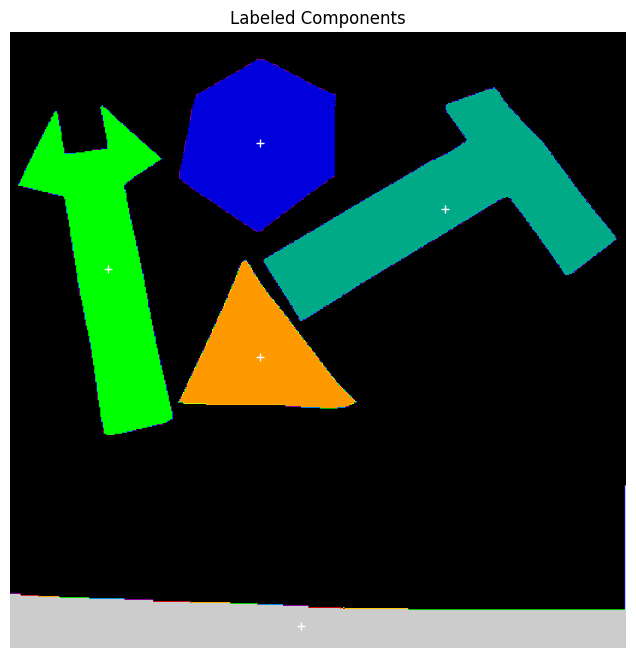

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(C, cmap='nipy_spectral')
plt.axis('off')
plt.title("Labeled Components")

for f in features.values():
    cy, cx = f["centroid"]
    plt.plot(cx, cy, 'w+')
